In [ ]:
import ast
import inspect
import json
import os
from inspect import Parameter
import openai
from dotenv import load_dotenv
from pydantic import create_model
from fastcore.utils import nested_idx
import logging

In [ ]:
openai.api_key = 'sk-....'

## calling GPT

In [ ]:
def askgpt(user, system=None, model="gpt-3.5-turbo", **kwargs):
    """Queries the OpenAI GPT model.

    Args:
        user: The user input message.
        system: The system message, defaults to None.
        model: The GPT model to use, defaults to "gpt-3.5-turbo".
        **kwargs: Additional arguments for the ChatCompletion.create call.

    Returns:
        The response from the GPT model.
    """
    msgs = [{"role": "user", "content": user}]
    if system:
        msgs.insert(0, {"role": "system", "content": system})
    return openai.ChatCompletion.create(model=model, messages=msgs, **kwargs)


r = askgpt("Hello, I'm a chatbot.")
r

<OpenAIObject chat.completion id=chatcmpl-8CDEc1og5b4dBizd4jD6CgTi5W7C7 at 0x1142950d0> JSON: {
  "id": "chatcmpl-8CDEc1og5b4dBizd4jD6CgTi5W7C7",
  "object": "chat.completion",
  "created": 1697921502,
  "model": "gpt-3.5-turbo-0613",
  "choices": [
    {
      "index": 0,
      "message": {
        "role": "assistant",
        "content": "Hello! Nice to meet you, chatbot. How can I assist you today?"
      },
      "finish_reason": "stop"
    }
  ],
  "usage": {
    "prompt_tokens": 15,
    "completion_tokens": 17,
    "total_tokens": 32
  }
}

## parsing GPT output

In [ ]:
def response(compl):
    """Prints the content of the message from the given response."""
    print(nested_idx(compl, "choices", 0, "message", "content"))


response(r)

Hello! Nice to meet you, chatbot. How can I assist you today?


## function schema

In [ ]:
def sum(a: int, b: int = 1) -> int:
    """Adds two numbers together.

    Args:
        a: The first number.
        b: The second number.

    Returns:
        The sum of the two numbers.
    """
    return a + b

In [ ]:
def schema(f):
    """Generates a schema for a given function using pydantic and inspect.

    Args:
        f: The function to generate a schema for.

    Returns:
        A dictionary containing the function name, its description, and parameters.
    """
    params = inspect.signature(f).parameters
    kw = {
        n: (o.annotation, ... if o.default == Parameter.empty else o.default)
        for n, o in params.items()
    }
    s = create_model(f"Input for `{f.__name__}`", **kw).model_json_schema()

    return {"name": f.__name__, "description": f.__doc__, "parameters": s}

schema(sum)

{'name': 'sum',
 'description': 'Adds two numbers together.\n\n    Args:\n        a: The first number.\n        b: The second number.\n\n    Returns:\n        The sum of the two numbers.\n    ',
 'parameters': {'properties': {'a': {'title': 'A', 'type': 'integer'},
   'b': {'default': 1, 'title': 'B', 'type': 'integer'}},
  'required': ['a'],
  'title': 'Input for `sum`',
  'type': 'object'}}

## function calling

In [ ]:
r = askgpt("What is 1+1?", system="You must use the sum function", functions=[schema(sum)])
r

<OpenAIObject chat.completion id=chatcmpl-8CDEdQG2ngwl4YcA5YOQ3pWO1FTYp at 0x1143c7330> JSON: {
  "id": "chatcmpl-8CDEdQG2ngwl4YcA5YOQ3pWO1FTYp",
  "object": "chat.completion",
  "created": 1697921503,
  "model": "gpt-3.5-turbo-0613",
  "choices": [
    {
      "index": 0,
      "message": {
        "role": "assistant",
        "content": null,
        "function_call": {
          "name": "sum",
          "arguments": "{\n  \"a\": 1,\n  \"b\": 1\n}"
        }
      },
      "finish_reason": "function_call"
    }
  ],
  "usage": {
    "prompt_tokens": 95,
    "completion_tokens": 21,
    "total_tokens": 116
  }
}

## parsing and running python code

In [ ]:
def run(code: str):
    """Executes the given Python code and returns the result.

    Args:
        code: The Python code to execute.

    Returns:
        The result of the executed code.
    """
    tree = ast.parse(code)
    last_node = tree.body[-1] if tree.body else None

    # If the last node is an expression, modify the AST to capture the result
    if isinstance(last_node, ast.Expr):
        tgts = [ast.Name(id="_result", ctx=ast.Store())]
        assign = ast.Assign(targets=tgts, value=last_node.value)
        tree.body[-1] = ast.fix_missing_locations(assign)

    ns = {}
    exec(compile(tree, filename="<ast>", mode="exec"), ns)
    return ns.get("_result", None)

def python(code: str):
    """Prompts the user to execute a Python code and returns the result.

    Args:
        code: The Python code to possibly execute.

    Returns:
        The result of the executed code or "#FAIL#" if user decides not to run it.
    """
    go = input(f"Run this code (y|n) ?\n```\n{code}\n```\n")
    if go.lower() != "y":
        return "#FAIL#"
    return run(code)

python("1 + 1")

2

## calling functions 

In [ ]:
def call_func(c, verbose=False):
    """Calls a function based on a message choice.

    Args:
        c: The response containing the function to call.

    Returns:
        The result of the called function or a message indicating any errors.
    """
    fc = nested_idx(c, "choices", 0, "message", "function_call")

    if not fc:
        return "No function created, try again..."

    # check that it's not running arbitrary code
    if fc.name not in {"python", "sum"}:
        return f"Not allowed: {fc.name}"
    
    try:
        # Try to decode the arguments as JSON
        args = json.loads(fc.arguments)
        
        if verbose:
            print(args['code'])

        # If decoding is successful, call the function with the parsed arguments
        f = globals()[fc.name]
        return f(**args)
    except json.JSONDecodeError:
        # If decoding fails, treat the arguments as raw Python code and evaluate it
        if verbose:
            print(fc.arguments)
        return run(fc.arguments)
    
call_func(r)

2

## code interpreter

In [ ]:
def code_interpreter(query, verbose=True):
    """Interprets the given query.

    Args:
        query: The query to interpret.

    Returns:
        The result of the interpreted query.
    """
    c = askgpt(
        query,
        system="Use Python for any required computation",
        functions=[schema(python)],
    )
    # check if function call is present
    if nested_idx(c, "choices", 0, "message", "function_call"):
        return call_func(c, verbose)

    return response(c)

## Examples

In [ ]:
code_interpreter("What is the square root of 420?")

import math

math.sqrt(420)


20.493901531919196

In [ ]:
code_interpreter("Convert 'hello world' to uppercase.")

'hello world'.upper()


'HELLO WORLD'

In [ ]:
code_interpreter("Generate the first 10 prime numbers.")

def is_prime(n):
    if n <= 1:
        return False
    for i in range(2, int(n**0.5) + 1):
        if n % i == 0:
            return False
    return True

primes = []
num = 2
while len(primes) < 10:
    if is_prime(num):
        primes.append(num)
    num += 1

primes


[2, 3, 5, 7, 11, 13, 17, 19, 23, 29]

In [ ]:
code_interpreter("What is today's date (in dd/mm/yyyy) and the day of the week?")

from datetime import date

today = date.today()

today_date = today.strftime("%d/%m/%Y")
today_weekday = today.strftime("%A")

today_date, today_weekday


('21/10/2023', 'Saturday')

In [ ]:
code_interpreter("Write a Python snippet to create a file named 'test.txt' and write 'Hello, OpenAI' in it.")

file_name = 'test.txt'
file_content = 'Hello, OpenAI'

with open(file_name, 'w') as file:
    file.write(file_content)

file_name


'test.txt'

In [ ]:
with open("test.txt", "r") as f:
    print(f.read())

Hello, OpenAI


In [ ]:
sample_str = 'please contant help@openai.com or support@openai.com'
code_interpreter(f"Extract all email addresses from the string: {sample_str} for more information.")

import re

def extract_email_addresses(text):
    pattern = r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b'
    email_addresses = re.findall(pattern, text)
    return email_addresses

text = "please contant help@openai.com or support@openai.com for more information."
email_addresses = extract_email_addresses(text)
email_addresses


['help@openai.com', 'support@openai.com']

In [ ]:
code_interpreter("Calculate the 10th number in the Fibonacci sequence.")

def fibonacci(n):
    if n <= 0:
        return 0
    elif n == 1:
        return 1
    else:
        return fibonacci(n-1) + fibonacci(n-2)

fibonacci(10)


55

In [ ]:
code_interpreter("Fetch the title of the website 'https://www.openai.com'.")

import requests
from bs4 import BeautifulSoup

url = 'https://www.openai.com'
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')
title = soup.title.string
title


'OpenAI'

In [ ]:
code_interpreter("Use numpy to calculate the average of the numbers: 10, 20, 30, 40, 50."s)

import numpy as np

numbers = [10, 20, 30, 40, 50]
average = np.mean(numbers)
average


30.0

In [ ]:
code_interpreter("Read the dataset cities.csv and calculate the average Price.")

import pandas as pd

# Read the dataset
df = pd.read_csv('cities.csv')

# Calculate the average Price
average_price = df['Price'].mean()

average_price


23.590000000000003

import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file
df = pd.read_csv('cities.csv')

# Plot the distribution of Price
plt.hist(df['Price'], bins=10)
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Distribution of Price')
plt.show()


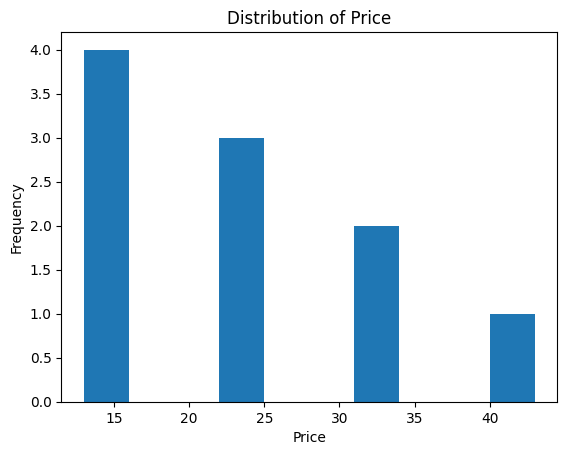

In [ ]:
code_interpreter("Plot the distribution of Price in cities.csv")

In [ ]:
code_interpreter("What's the meaning of life?")

The meaning of life is a philosophical question that has been debated by humans for centuries. Different people and cultures have different interpretations and beliefs about the purpose and meaning of life. Some may find meaning in religious or spiritual beliefs, while others may find meaning in relationships, personal achievements, or the pursuit of knowledge and happiness. Ultimately, the meaning of life is subjective and can vary from person to person.


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=a605a3e6-1564-47b2-94e7-842290ba7692' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>